In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import torch
import torch.nn.functional as F
import matplotlib.ticker as plticker
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from collections import defaultdict
from typing import Optional
from scipy.integrate import solve_ivp
from scipy.fftpack import diff as psdiff

torch.set_default_dtype(torch.float64)
# torch.set_default_device('cuda:0')
torch.set_default_device('cpu')

torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0), torch.cuda.get_device_name(0)

(True,
 1,
 0,
 'NVIDIA RTX A5000 Laptop GPU')

In [2]:
def generate_params() -> (int, np.ndarray, np.ndarray, np.ndarray):
    """
    Returns parameters for initial conditions.
    Args:
        None
    Returns:
        int: number of Fourier series terms
        np.ndarray: amplitude of different sine waves
        np.ndarray: phase shift of different sine waves
        np.ndarray: frequency of different sine waves
    """
    N = 10
    lmin, lmax = 1, 3
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0*np.pi*np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return (N, A, phi, l)

def initial_conditions(x: np.ndarray, L: int, params: Optional[list]=None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    Args:
        x (np.ndarray): input array of spatial grid
        L (float): length of the spatial domain
        params (Optinal[list]): input parameters for generating initial conditions
    Returns:
        np.ndarray: initial condition
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params   
    u = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L ) + phi), -1)
    return u

Kuramoto-Shivashinsky 
$$u_t + u_{xx} + u_{xxxx} + u u_x = 0 $$

has symmetries generated by 
$$(x, t+\varepsilon, u), (x+\varepsilon, t, u), (x + \varepsilon t, t, u + \varepsilon) $$

which are time and spatial translation, and a Galilean boost: 
$$(\partial_t, \partial_x, t\partial_x - \partial_u) $$
respectively. These generators have the following operator matrices

In [3]:
L0 = lambda d,z: np.sum([2*np.pi*p/d**2 * np.sin(2*np.pi*p/d *z) for p in np.arange(-d/2+1,d/2)], axis=0)

(0.0, 25.0)

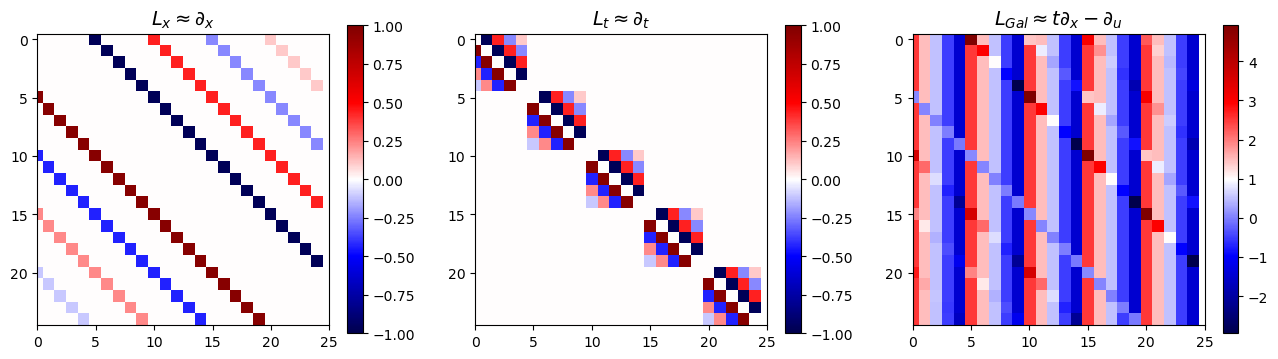

In [4]:
d = 5
coords = np.mgrid[:d, :d] - d/2

x, t = coords.reshape((2, -1))

dx = (x[:,np.newaxis]-x) * (t[:,np.newaxis]==t) # make sure distance calculated only for the same y
dt = (t[:,np.newaxis]-t) * (x[:,np.newaxis]==x) # ... same x

Lx = L0(2*d, dx) 
Lt = L0(2*d, dt)
LGal = np.diag(t) @ Lx - t # treat t as u? 

#fig, axes = plt.subplots(3, 1, figsize=(16, 8))

plt.figure(figsize=(16, 4))

plt.subplot(131)
plt.imshow(Lx, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar() 
plt.title(r"$L_x \approx \partial_x$", size=14)
plt.xlim([0, Lx.shape[0]])
#plt.ylim([0, Lx.shape[0]])

plt.subplot(132)
plt.imshow(Lt, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar() 
plt.title(r"$L_t \approx \partial_t$", size=14)
plt.xlim([0, Lx.shape[0]])
#plt.ylim([0, Lx.shape[0]])


plt.subplot(133)
plt.imshow(LGal, cmap='seismic', vmin=LGal.min(), vmax=LGal.max())
plt.colorbar() 
plt.title(r"$L_{Gal} \approx t\partial_x - \partial_u$", size=14)
plt.xlim([0, Lx.shape[0]])
#plt.ylim([0, Lx.shape[0]])

In [5]:
def ks_pseudospectral_reconstruction(t: float, u: np.ndarray, L: float) -> np.ndarray:
        """
        Pseudospectral reconstruction of the spatial derivatives of the KS equation, discretized in x.
        Args:
            t (float): time point
            u (np.ndarray): 1D input field
            L (float): length of the spatial domain
        Returns:
            np.ndarray: reconstructed pseudospectral time derivative
        """
        # Compute the x derivatives using the pseudo-spectral method.
        ux = psdiff(u, period=L)
        uxx = psdiff(u, period=L, order=2)
        uxxxx = psdiff(u, period=L, order=4)
        # Compute du/dt.
        dudt = - u*ux - uxx - uxxxx
        return dudt

def to_coords(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Transforms the coordinates to a tensor X of shape [time, space, 2].
    Args:
        x: spatial coordinates
        t: temporal coordinates
    Returns:
        torch.Tensor: X[..., 0] is the space coordinate (in 2D)
                      X[..., 1] is the time coordinate (in 2D)
    """
    x_, t_ = torch.meshgrid(x, t)
    x_, t_ = x_.T, t_.T
    return torch.stack((x_, t_), -1)

L = 25 #64 #128
N = 25 #64 #2**7
x = np.linspace(0, (1-1.0/N)*L, N)
print(f"On interval [{x.min()}, {x.max()}] ")
# Set the tolerance of the solver
tol = 1e-6

# Set the initial conditions.
u0 = initial_conditions(x, L)

# Set the time sample grid.
T = 25 # 100.
t = np.linspace(0, T, T)
X = to_coords(torch.tensor(x), torch.tensor(t))

# Compute the solution using kdv_pseudospectral as spatial solver
sol_example = solve_ivp(fun=ks_pseudospectral_reconstruction, 
                               t_span=[t[0], t[-1]], 
                               y0=u0, 
                               method='Radau', 
                               t_eval=t, 
                               args=(L,), 
                               atol=tol, 
                               rtol=tol)



On interval [0.0, 24.0] 


/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
from common.augmentation import SpaceTranslate, Scale, Galileo


Root normalized mean squared error: 0.006110912613738939


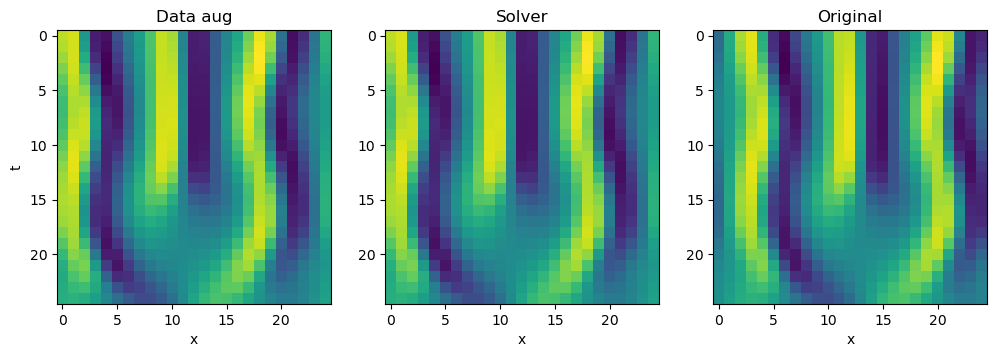

In [7]:
sample  = (torch.tensor(sol_example.y.T), X)
#print(sample)
sol = SpaceTranslate(max_x_shift=0.5)(sample=sample, shift='fourier')
#sol = Galileo(max_velocity=1)(sample=sol, shift='fourier')

soln, Xn = sol[0].cpu().numpy(), sol[1].cpu().numpy()


N = Xn.shape[-2]
Xmax = (Xn[0, -1, 0] - Xn[0, 0, 0]) * (N+1) / N
Tmax = Xn[-1, 0, 1] - Xn[0, 0, 1]
t = np.linspace(0, Tmax, soln.shape[0])
sol_crosscheck = solve_ivp(ks_pseudospectral_reconstruction, [t[0], t[-1]], soln[0, :], method='Radau', t_eval=t, args=(Xmax,), atol=tol, rtol=tol)

# Calulate the normalized mse between augmented and crosscheck trajectory
mse = np.mean((sol_crosscheck.y.T - soln)**2)
normed_mse = mse / np.mean(sol_crosscheck.y.T**2)
root_normed_mse = np.sqrt(normed_mse)
print(f'Root normalized mean squared error: {root_normed_mse}')

fig, axes = plt.subplots(1, 3, figsize=(12,8))
axes[0].imshow(soln[::-1]) #, extent=[0,Xmax,0,Tmax])
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Data aug')


axes[1].set_title('Solver')
axes[1].imshow(sol_crosscheck.y.T[::-1]) #, extent=[0,Xmax,0,Tmax])
axes[1].set_xlabel('x')

axes[2].set_title('Original')
axes[2].imshow(sol_example.y.T[::-1]) #, extent=[0,Xmax,0,Tmax])
axes[2].set_xlabel('x')

for ax in axes:
    ax.set_anchor('S')
plt.show()


In [8]:
def initial_conditions(A: np.ndarray, phi: np.ndarray, l: np.ndarray, L: float):
    """
    Return initial conditions based on initial parameters.
    Args:
        A (np.ndarray): amplitude of different sine waves
        phi (np.ndarray): phase shift of different sine waves
        l (np.ndarray): frequency of different sine waves
        L (float): length of the spatial domain
    Returns:
        None
    """
    def fnc(x):
        u = np.sum(A * np.sin(2 * np.pi * l * x / L + phi), -1)
        return u
    return fnc

def params():
    """
    Get initial parameters for KdV, KS, and Burgers' equation.
    Args:
        batch_size (int): batch size
        device: device (cpu/gpu)
    Returns:
        np.ndarray: amplitude of different sin waves
        np.ndarray: phase shift
        np.ndarray: space dependent frequency
    """
    A = np.random.rand(1, 10) - 0.5
    phi = 2.0 * np.pi * np.random.rand(1, 10)
    l = np.random.randint(1, 3, (1, 10))
    return A, phi, l


In [9]:
from torchvision import datasets
from tqdm import tqdm

L = 25 #64 #128
N = 25 #64 #2**7
x = np.linspace(0, (1-1.0/N)*L, N)
print(f"On interval [{x.min()}, {x.max()}] ")
# Set the tolerance of the solver
tol = 1e-6

# Set the time sample grid.
T = 25 # 100.
t = np.linspace(0, T, T)
X = to_coords(torch.tensor(x), torch.tensor(t))


class RandKS(datasets.VisionDataset): 
    def __init__(self, *args,  dataseed=0, N=1000, size=(25, 25), max_x_shift=0.5, max_velocity=1., train=True, **kwargs):

        super().__init__(*args, **kwargs)
        torch.manual_seed(dataseed) 
        
        self.data = torch.zeros((N, 1, size[0], size[1]))
        self.data_aug = torch.zeros((N, 1, size[0], size[1]))
        #self.params = torch.zeros((N, 3))

        with torch.no_grad():  
            for idx in tqdm(range(N)): 
            # TODO: ensure that fixed seed is used
                A, phi, l = params() 
          #      print(A.shape, phi.shape, l.shape)

                u0 = initial_conditions(A, phi, l, L)(x[:, None])

                sol_example = solve_ivp(fun=ks_pseudospectral_reconstruction, 
                                   t_span=[t[0], t[-1]], 
                                   y0=u0, 
                                   method='Radau', 
                                   t_eval=t, 
                                   args=(L,), 
                                   atol=tol, 
                                   rtol=tol)
                
                #self.data[idx] = torch.tensor(sol_example.y.T[::-1].copy())
                self.data[idx] = torch.tensor(sol_example.y.T.copy())
                
                sample = (torch.tensor(sol_example.y.T), X)

                sol = SpaceTranslate(max_x_shift=max_x_shift)(sample=sample, shift='fourier')

                soln, Xn = sol[0], sol[1]

                self.data_aug[idx] = soln # [::-1]
         #       self.params[idx] = torch.tensor([A, phi, l])


    def __getitem__(self, idx): 
        return (self.data[idx], self.data_aug[idx]), 1. # TODO: needs param for problem 
    
    def __len__(self): 
        return len(self.data)     

On interval [0.0, 24.0] 


In [10]:
dataset = RandKS
batch_size = 16
test_batch_size = 10
# device = torch.device("cuda")
device = torch.device("cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
# if use_cuda:
cuda_kwargs = {'num_workers': 1,
               'pin_memory': True,
               'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

dataset1 = dataset('../data', N=5000)
dataset2 = dataset('../data', N=1000)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

100%|██████████| 1000/1000 [00:49<00:00, 20.03it/s]


In [11]:
import os 
from pathlib import Path 

if not os.path.exists(Path().resolve() / "cpu_ks_space_train5000.pt"):
    torch.save(train_loader, "cpu_ks_space_train5000.pt")
if not os.path.exists(Path().resolve() / "cpu_ks_space_test1000.pt"):
    torch.save(test_loader, "cpu_ks_space_test1000.pt")


(1, 25, 25)


Text(0.5, 1.0, 'Augmented Data')

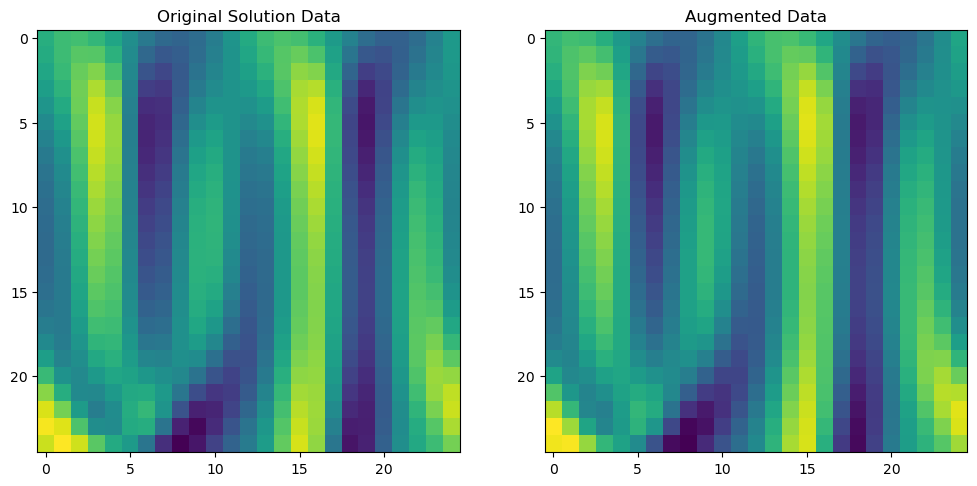

In [12]:
(data, data_aug), t = dataset1.__getitem__(2) 

print(data.cpu().numpy()[::-1].shape)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data.cpu().numpy().squeeze())
# plt.colorbar() 
plt.title("Original Solution Data")


plt.subplot(122)
plt.imshow(data_aug.cpu().numpy().squeeze())
# plt.colorbar() 
plt.title("Augmented Data")


In [13]:
from time import time
class trainer():
    def __init__(self, model, device, optimizer, dataset_class = None, 
                 train_loader=None, test_loader=None,
                 batch_size = 64, test_batch_size = 1000,loss_func = F.nll_loss,
                ):
        """
        usage:
            t = trainer(...)
            t.fit(epochs)
            
        methods:
            .fit(epochs) : train + test; print results; stores results in trainer.history <dict>
            .train(epoch)
            .test()
        """
        self.device = device #torch.device(device)
        self.optimizer = optimizer
        self.model = model
        self.loss_func = loss_func

        self.scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
        self.history = {'train loss':[], 'test loss':[], 'train acc':[], 'test acc':[], 'train time':[]}
        
        if dataset_class:
            self.make_dataloaders(dataset_class, batch_size, test_batch_size)
        else:
            self.train_loader = train_loader 
            self.test_loader = test_loader
        
    def make_dataloaders(self, dataset_class, batch_size, test_batch_size):
        train_kwargs = {'batch_size': batch_size}
        test_kwargs = {'batch_size': test_batch_size}
        if self.device.type =='cuda':        
            cuda_kwargs = {'num_workers': 1,
                           'pin_memory': True,
                           'shuffle': True}
            train_kwargs.update(cuda_kwargs)
            test_kwargs.update(cuda_kwargs)
        
        print('Creating data loaders...',end='')
        dataset1 = dataset_class('../data', train=True, download=True,)
        dataset2 = dataset_class('../data', train=False,)

        self.train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
        self.test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
        print('Done')

#         self.optimizer = optimizer
#         self.model, self.device, self.train_loader,  = model, device, train_loader,
#         self.test_loader = test_loader
        
    def progbar(self,percent, N=10):
        n = int(percent//N)
        return '[' + '='*n + '>' +'.'*(N-n-1) +']'
    
    def train(self,epoch):
        self.model.train()
        training_loss = 0
        correct = 0
        t0 = time()
        for batch_idx, (data, target) in enumerate(self.train_loader):
            # print(type(data))
            if type(data)==list:
                data = [d.to(self.device) for d in data]
            else:
                data = data.to(self.device)
            if type(target)==list:
                target = [d.to(self.device) for d in target]
            else:
                target = target.to(self.device)
                
#             data, target = data.to(self.device), target.to(self.device)
            # self.optimizer.zero_grad()
            # print(f"data len: {len(data)}")
            # 
            # print(f"target len: {len(target)}")
            # print(self.model(data).shape)


            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_func(output, target)
            training_loss += loss.sum().item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            loss.backward(retain_graph=True)
            self.optimizer.step()
            if batch_idx % 10 == 0:
                perc = 100. * batch_idx / len(self.train_loader)
                t1 = time()
                print('Train Epoch: {} {} {:.1f}s [{}/{} ({:.0f}%)]\tLoss: {:.4g}'.format(
                    epoch, self.progbar(perc), t1-t0,
                    batch_idx * len(data), len(self.train_loader.dataset), # n/N
                    perc, # % passed
                    loss.item()), end='\r')
        
        training_loss /= len(self.train_loader.dataset)
        acc = correct / len(self.train_loader.dataset)    
        print('\nTraining: loss: {:.4g}, Acc: {:.2f}%'.format(training_loss, 100.*acc))
            
        return {'loss':training_loss, 'acc':acc , 'time':t1-t0}
                
        
    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                if type(data)==list:
                    data = [d.to(self.device) for d in data]
                else:
                    data = data.to(self.device)
                if type(target)==list:
                    target = [d.to(self.device) for d in target]
                else:
                    target = target.to(self.device)
                #data, target = data.to(self.device), target.to(self.device)
                # print(data.shape)
                # print(self.model(data).shape)
                output = self.model(data)
                test_loss += self.loss_func(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        
        test_loss /= len(self.test_loader.dataset)
        test_acc = correct / len(self.test_loader.dataset)
        
        print('Test loss: {:.4g}, Test acc.: {:.2f}%'.format( test_loss, 100.*test_acc))
        return {'loss':test_loss, 'acc':test_acc}
    
    def fit(self,epochs=1):
        for epoch in range(1, epochs + 1):
            r = self.train(epoch)
            self.history['train loss'] += [r['loss']]
            self.history['train acc'] += [r['acc']]
            self.history['train time'] += [r['time']]
            
            r = self.test()
            self.history['test loss'] += [r['loss']]
            self.history['test acc'] += [r['acc']]
            self.scheduler.step()

In [14]:
from torch import nn, optim 
from torch.optim.lr_scheduler import StepLR


class Lconv_core(nn.Module):
    """ L-conv layer with full L """
    def __init__(self,d,num_L=1,cin=1,cout=1,rank=8):
        """
        L:(num_L, d, d)
        Wi: (num_L, cout, cin)
        """
        super().__init__()
        self.L = nn.Parameter(torch.Tensor(num_L, d, d))
        self.Wi = nn.Parameter(torch.Tensor(num_L, cout, cin))
        
        # initialize weights and biases
        nn.init.kaiming_normal_(self.L) 
        nn.init.kaiming_normal_(self.Wi)
                
    def forward(self, x):
        # x:(batch, channel, flat_d)
        # h = (x + Li x Wi) W0
        y = torch.einsum('kdf,bcf,koc->bod', self.L, x, self.Wi ) + x #+ self.b        
        return y


class Net(nn.Module):
    def __init__(self,d,c,device,k=1, rec=1, hid = 5):
        super().__init__()
        self._rec = rec
        self._c = c
#         with torch.no_grad():
        self.ones = torch.ones((1,c,1)).to(device)
        self.LC = Lconv_core(d=d,num_L=k,cin=c,cout=c)
        self.flat = nn.Flatten(2)
        self.lin1 = nn.Linear(c,hid)
        self.out = nn.Linear(hid,1)
        
    def forward(self, inp):
        # print(len(inp), inp[0].shape)
        
        x,y = inp
        # x,y->(batch, channel, flat_d)
        x = self.flat(x)
        y = self.flat(y)
        # copy input to c channels
        x = x * self.ones
        # pass through L-conv
        for _ in range(self._rec):
            x = self.LC(x)
        x = torch.einsum('bcd,bad->bc', x, y)
        x = F.tanh(x)
        x = self.lin1(x)
        x = F.tanh(x) 
        return self.out(x)

In [15]:
s = dataset1.data[0].shape
d = np.prod(s)
# lc = Lconv_2(k=2,d=d, cin=1, cout=1, rank=50)
rec = 10
# model = Net(d,10,k=1,device=device,rec=rec).to(device)

model = Net(d,10,k=1,device=device,rec=rec).to(device)
optimizer = optim.Adam(model.parameters(),lr = 1e-3)
trainer = trainer(model, device, optimizer, train_loader=train_loader, test_loader=test_loader, 
            #dataset_class=AugRotMNIST__0, #dataset, 
            loss_func=F.mse_loss)


In [16]:
trainer.fit(25)

/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/utils/_device.py:62: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


Train Epoch: 1 [=========>] 7.5s [620/5000 (99%)]	Loss: 0.004087
Training: loss: 0.009166, Acc: 0.00%


/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/utils/_device.py:62: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/home/ai/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/utils/_device.py:62: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


Test loss: 0.03951, Test acc.: 0.00%
Train Epoch: 2 [=========>] 6.7s [620/5000 (99%)]	Loss: 0.0012385
Training: loss: 0.0001362, Acc: 0.00%
Test loss: 0.0296, Test acc.: 0.00%
Train Epoch: 3 [=========>] 6.7s [620/5000 (99%)]	Loss: 0.0011764
Training: loss: 9.481e-05, Acc: 0.00%
Test loss: 0.008747, Test acc.: 0.00%
Train Epoch: 4 [=========>] 6.9s [620/5000 (99%)]	Loss: 0.0009319
Training: loss: 3.7e-05, Acc: 0.00%
Test loss: 0.009727, Test acc.: 0.00%
Train Epoch: 5 [=========>] 6.5s [620/5000 (99%)]	Loss: 0.0004115
Training: loss: 3.345e-05, Acc: 0.00%
Test loss: 0.003235, Test acc.: 0.00%
Train Epoch: 6 [=========>] 6.3s [620/5000 (99%)]	Loss: 0.0001654
Training: loss: 1.835e-05, Acc: 0.00%
Test loss: 0.002298, Test acc.: 0.00%
Train Epoch: 7 [=========>] 6.7s [620/5000 (99%)]	Loss: 0.0003519
Training: loss: 1.465e-05, Acc: 0.00%
Test loss: 0.001961, Test acc.: 0.00%
Train Epoch: 8 [=========>] 6.6s [620/5000 (99%)]	Loss: 0.0001628
Training: loss: 1.297e-05, Acc: 0.00%
Test loss: 

Text(0.5, 0, 'Epochs')

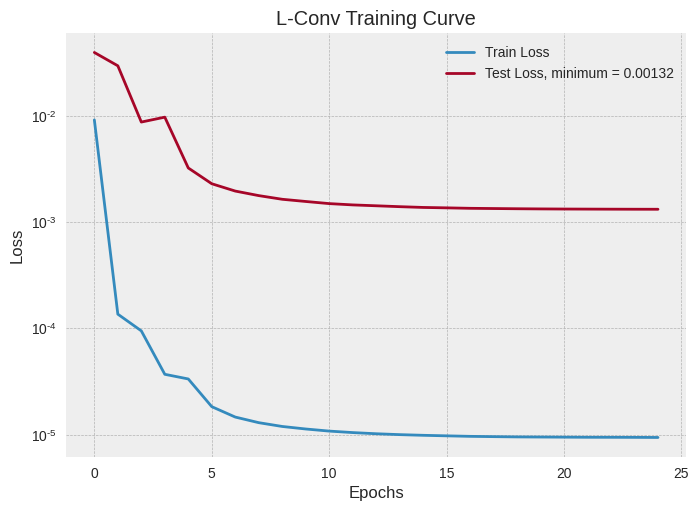

In [55]:
# for k in ['train loss', 'test loss']:
    # plt.plot(trainer.history[k], label=k)
import matplotlib as mpl 
mpl.style.use('bmh')

plt.plot(trainer.history['train loss'], label="Train Loss")
plt.plot(trainer.history['test loss'], label=f"Test Loss, minimum = {min(trainer.history['test loss']):.3g}")


plt.title(f'L-Conv Training Curve')
plt.legend()
plt.yscale('log')
plt.grid('true')

plt.ylabel('Loss')
plt.xlabel('Epochs')

In [18]:
lc = model.LC
Ls = lc.L.detach().cpu().numpy()
#L_small = (lc.L*lc.Wi).detach().cpu().numpy()[0]

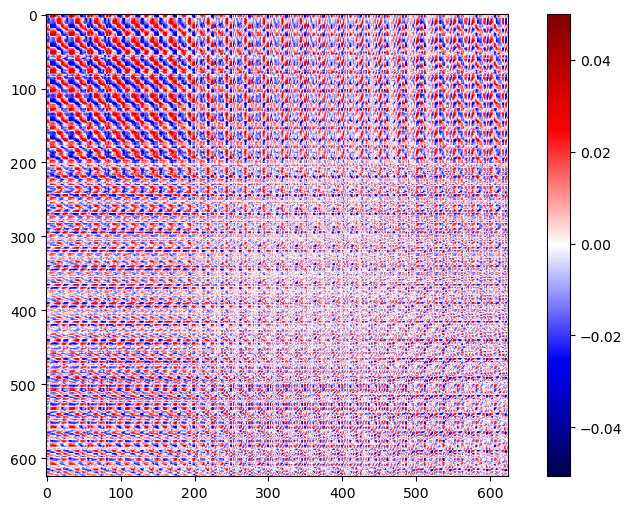

In [19]:
coscorr = lambda x,y: np.trace(x.T@y)/np.linalg.norm(x)/np.linalg.norm(y)


plt.figure(figsize=(10,6))
for i in range(len(Ls)):
    plt.subplot(1,len(Ls), i+1)
    plt.imshow(Ls[i].T,cmap='seismic') # , vmin = -1, vmax = 1
    plt.title("")
    #plt.title(fr"Learned Operator matrix, Corr = {coscorr(Ls[i].T, Lx)}")
    plt.colorbar()
    

In [20]:
data, target = next(iter(test_loader))

d = data[0].to(device)
da = data[1]

Text(0.5, 0.98, 'L-Conv RMSE: 0.2445777517930053')

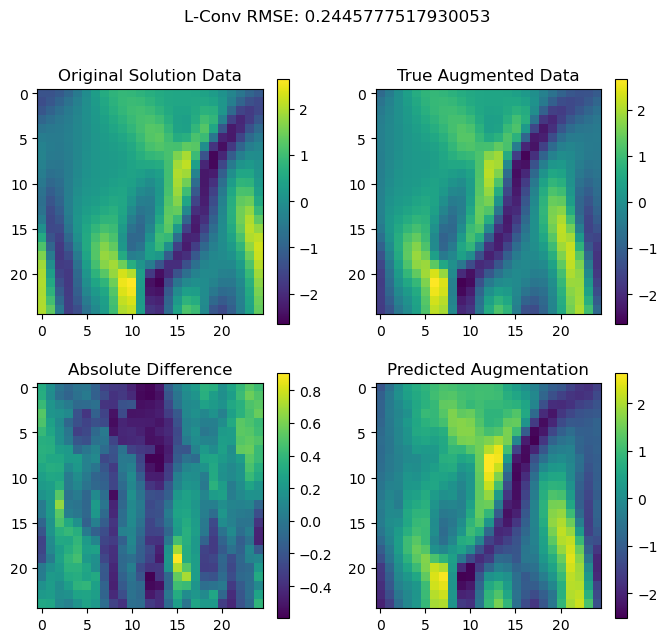

In [48]:
data_idx = 5
data_sample = d[data_idx]
data_aug_sample = da[data_idx]
data_aug_learned = model.LC(nn.Flatten(2)(d))
data_aug_learned_curr_sample = data_aug_learned.cpu().detach().numpy().squeeze()[data_idx, -1].reshape(25,25)
mse = np.mean((data_sample.numpy().squeeze() - data_aug_learned_curr_sample)**2)
norm_mse = mse / np.mean(data_aug_learned_curr_sample**2)
rmse = np.sqrt(norm_mse)

plt.figure(figsize=(8, 7)) 

plt.subplot(221) 
plt.imshow(data_aug_sample.cpu().numpy().squeeze()) 
plt.title("Original Solution Data") 
plt.colorbar() 

plt.subplot(222)  
plt.imshow(data_sample.numpy().squeeze()) 
plt.title("True Augmented Data")
plt.colorbar() 

plt.subplot(223) 
plt.imshow(data_sample.numpy().squeeze() - data_aug_learned_curr_sample)
plt.colorbar()
plt.title("Absolute Difference")

plt.subplot(224) 
plt.imshow(data_aug_learned_curr_sample)
plt.colorbar() 
plt.title("Predicted Augmentation")

plt.suptitle("L-Conv RMSE: " + f"{rmse}")

Text(0.5, 0.98, 'L-Conv RMSE: 1.7859243588213598')

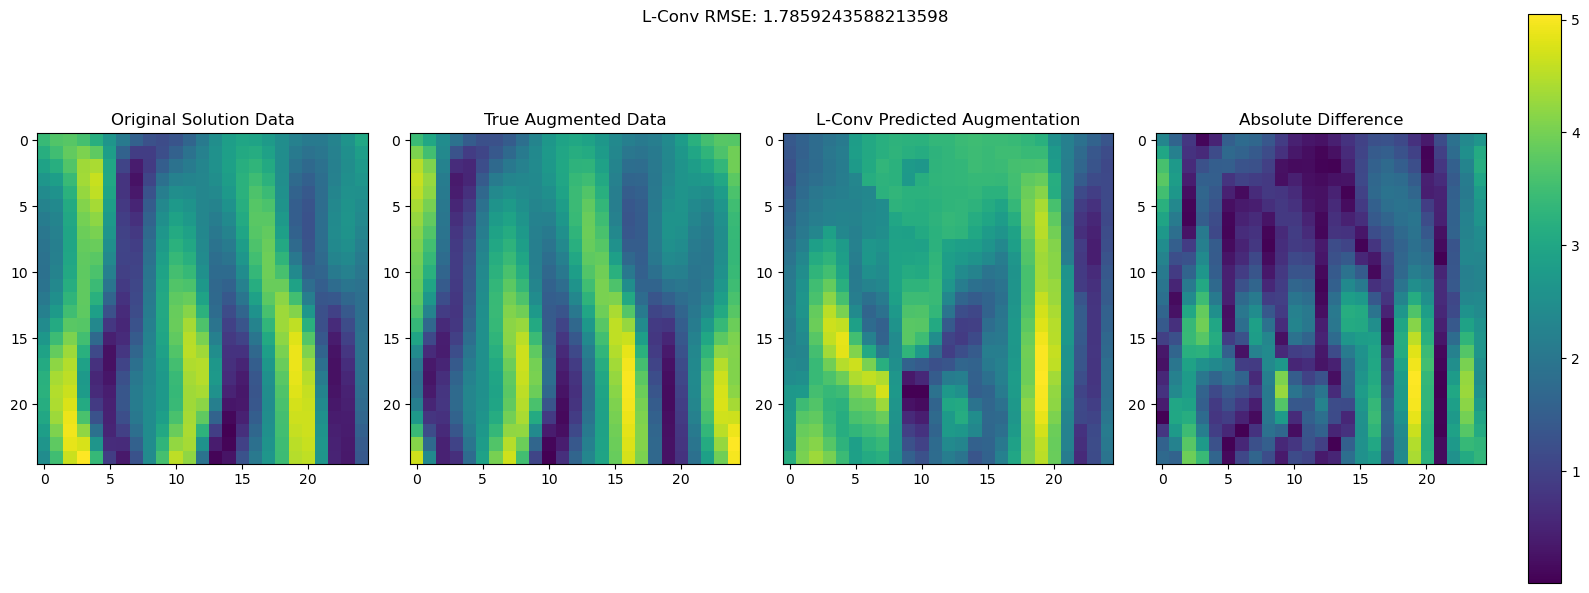

In [21]:
data_idx = 2
data_sample = d[data_idx]
data_aug_sample = da[data_idx]
data_aug_learned = model.LC(nn.Flatten(2)(d))
data_aug_learned_curr_sample = data_aug_learned.cpu().detach().numpy().squeeze()[data_idx, -1].reshape(25,25)
mse = np.mean((data_aug_sample.numpy().squeeze() - data_aug_learned_curr_sample)**2)
norm_mse = mse / np.mean(data_aug_learned_curr_sample**2)
rmse = np.sqrt(norm_mse)
#data_aug_learned = model.LC(nn.Flatten()(data))

# print(data.numpy()[::-1].shape)

gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}
fig, ax = plt.subplots(1, 5, figsize=(16, 6), gridspec_kw=gridspec)
# plt.figure(figsize=(16, 4))
# plt.subplot(141)
ax[0].imshow(data_sample.cpu().numpy().squeeze())

# plt.imshow(data_sample.cpu().numpy().squeeze())
# plt.imshow(d)

# plt.colorbar() 
ax[0].title.set_text("Original Solution Data")


# plt.subplot(142)
# plt.imshow(data_aug_sample.numpy().squeeze())
ax[1].imshow(data_aug_sample.numpy().squeeze())


# plt.imshow(data_aug_true.numpy().squeeze())
# plt.colorbar() 
ax[1].title.set_text("True Augmented Data")
# plt.title("True Augmented Data")

# plt.subplot(143)
# plt.imshow(data_aug_learned.numpy().squeeze())
# plt.colorbar() 
ax[2].imshow(data_aug_learned.cpu().detach().numpy().squeeze()[0, -1].reshape(25,25))


ax[2].title.set_text("L-Conv Predicted Augmentation")

# plt.subplot(144) 

plt.sca(ax[3])
im3absd = ax[3].imshow(np.abs(data_aug_sample.numpy().squeeze() - data_aug_learned.cpu().detach().numpy().squeeze()[0, -1].reshape(25,25)))
# plt.colorbar()
ax[3].title.set_text("Absolute Difference")

# for axes in ax[:4]: 
    # axes.set_aspect(10)
cax = ax[-1]
# vals = ax[3].get_children()[2]
plt.colorbar(im3absd, cax=cax)
plt.tight_layout()

plt.suptitle("L-Conv RMSE: " + f"{rmse}")



In [22]:
data, target = next(iter(test_loader))

data[0].shape

torch.Size([10, 1, 25, 25])

In [23]:
d.shape, da.shape, data.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
data_aug_learned.shape

torch.Size([16, 10, 625])

(1, 25, 25)


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

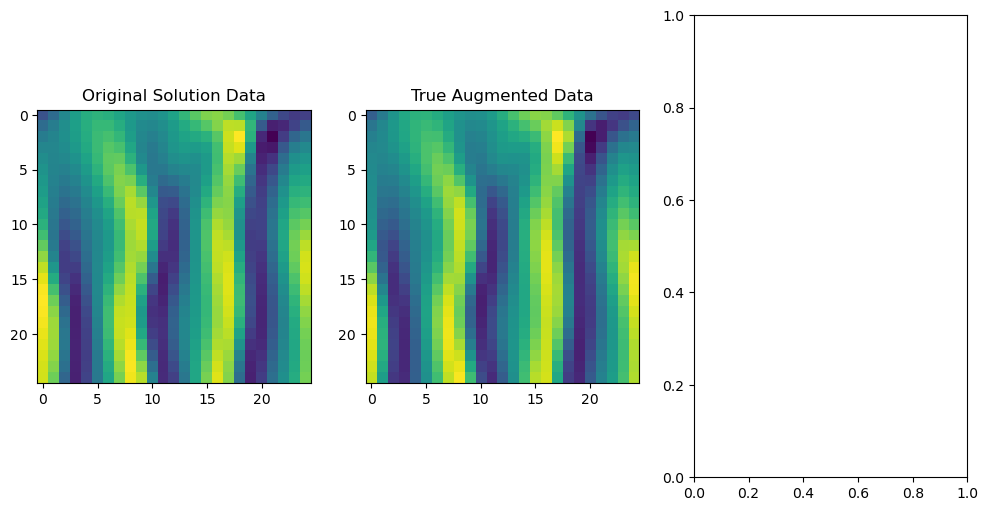

In [ ]:
(data, data_aug_true), temp = dataset1.__getitem__(2) 

# data_aug_learned = model((data, data_aug_true))
# data_aug_learned = model.LC(nn.Flatten(2)(data).squeeze())
# data_aug_learned = model.LC(nn.Flatten()(data))

print(data.numpy()[::-1].shape)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(data.numpy().squeeze())
# plt.colorbar() 
plt.title("Original Solution Data")


plt.subplot(132)
plt.imshow(data_aug_true.numpy().squeeze())
# plt.colorbar() 
plt.title("True Augmented Data")

plt.subplot(133)
plt.imshow(data_aug_learned.numpy().squeeze())
# plt.colorbar() 
plt.title("Augmented Data")



In [ ]:
model.ones.shape

torch.Size([1, 10, 1])

In [ ]:
nn.Flatten()(data).shape

torch.Size([1, 625])